
LOOKING AT WIDTH = 32, DEPTH = 2 


LOOKING AT WIDTH = 32, DEPTH = 4 


LOOKING AT WIDTH = 1024, DEPTH = 2 


LOOKING AT WIDTH = 1024, DEPTH = 4 


FINAL RESULTS:


Width: 32, Depth: 2
Average Train Loss: 141.17118911743165
Average Validation Loss: 812.6213390350342

Width: 32, Depth: 4
Average Train Loss: 22.664021921157836
Average Validation Loss: 290.58278079032897

Width: 1024, Depth: 2
Average Train Loss: 4.5542074859142305
Average Validation Loss: 104.14613702297211

Width: 1024, Depth: 4
Average Train Loss: 22.829794430732726
Average Validation Loss: 34.61234941482544

BEST HYPEPARAMETERS
Width: 1024
Depth: 4
Average Validation Loss: 34.61234941482544
Average Training Loss 22.829794430732726
450
50

Test Loss: 0.4849780201911926


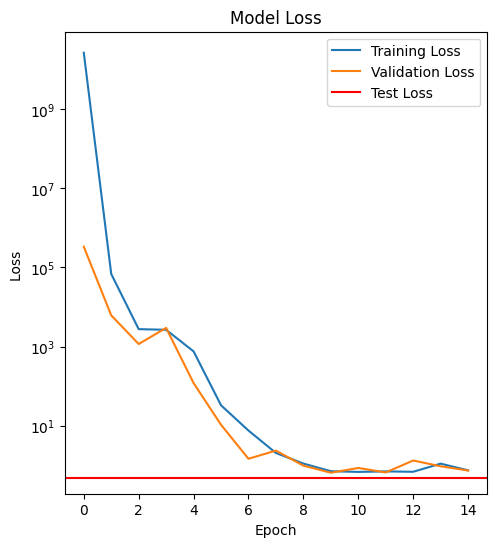

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


trainingArr = pd.read_csv('./train-1.csv')
testArr = pd.read_csv('./test.csv')

# Convert both to numpy arrays with the same format
x_test = testArr.drop('arousal', axis=1).values  # Add .values here
y_test = testArr['arousal'].values  # Add .values here
x_train = trainingArr.drop('arousal', axis=1).values
y_train = trainingArr['arousal'].values

allPossibleWidths = [32, 1024]
allPossibleDepths = [2, 4]

def create_model(curShape, width, depth):
    model = Sequential()
    model.add(Input(shape=(curShape,)))
    for i in range(depth):
        model.add(Dense(width, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])
    return model

def perform_cross_validation(x_train, y_train, width, depth):
    print(f"\nLOOKING AT WIDTH = {width}, DEPTH = {depth} \n")
    fold_train_losses = []
    fold_val_losses = []
    kf = KFold(n_splits=5)
    
    # Create early stopping callback
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=0
    )
    
    for fold, (train_index, val_index) in enumerate(kf.split(x_train), 1):
        x_train_fold = x_train[train_index]
        y_train_fold = y_train[train_index]
        x_val_fold = x_train[val_index]
        y_val_fold = y_train[val_index]
        model = create_model(x_train.shape[1], width, depth)
        history = model.fit(
            x_train_fold, 
            y_train_fold, 
            validation_data=(x_val_fold, y_val_fold),
            epochs=50,
            callbacks=[early_stop],
            verbose=0
        )
        
        # ONLY STORE LAST LOSS
        fold_train_losses.append(history.history['loss'][-1])
        fold_val_losses.append(history.history['val_loss'][-1])

    
    # taking mean of loss for validation and training
    avg_train_loss = np.mean(fold_train_losses)
    avg_val_loss = np.mean(fold_val_losses)
    return avg_train_loss, avg_val_loss


results = []

for width in allPossibleWidths:
    for depth in allPossibleDepths:
        avg_train_loss, avg_val_loss = perform_cross_validation(x_train, y_train, width, depth)
        results.append({'width': width,'depth': depth,'avg_val_loss': avg_val_loss, 'avg_train_loss': avg_train_loss})

print("\nFINAL RESULTS:\n")
for result in results:
    print(f"\n[Width: {result['width']}, Depth: {result['depth']}]")
    print(f"Average Train Loss: {result['avg_train_loss']}")
    print(f"Average Validation Loss: {result['avg_val_loss']}")

# getting best hyperparameters by looking through every hyperparameters object storing its avgTraining and avg validation loss and finding the min.
curMinVal = float('inf')
curBestObj = None
for result in results:
    if result["avg_val_loss"] < curMinVal:
        curMinVal = result["avg_val_loss"]
        curBestObj = result

print("\nBEST HYPEPARAMETERS")
print(f"Width: {curBestObj['width']}")
print(f"Depth: {curBestObj['depth']}")
print(f"Average Validation Loss: {curBestObj['avg_val_loss']}")
print(f"Average Training Loss {curBestObj['avg_train_loss']}")


# since im implementing early stopping, need to keep track of validation loss with 90:10 split
x_train_final, x_val_final, y_train_final, y_val_final = train_test_split(
    x_train, y_train, test_size=0.1, random_state=42
)


# doing final training with best hyperparameters
model2 = create_model(x_train.shape[1], curBestObj['width'], curBestObj['depth'])
early_stop2 = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=0
)

history2 = model2.fit(
    x_train_final, 
    y_train_final,
    validation_data=(x_val_final, y_val_final),
    epochs=100, 
    callbacks=[early_stop2],
    verbose=0
)

test_loss, test_mae = model2.evaluate(x_test, y_test, verbose=0)
print(f"\n Final Test Loss: {test_loss}")

#plot everything
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.yscale("log")
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss, color='r', label='Test Loss')
plt.title('Model Loss')
plt.ylabel('Loss ')
plt.xlabel('Epoch')
plt.legend()
plt.show()